In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [18]:
# CONFIG
INPUT_PATH = "../data_work/loans_cleaned.parquet"
OUTPUT_PATH = "../data_work/loans_fe.parquet"
TARGET_COL = 'target'
ID_COLS = ['id', 'issue_d', 'issue_q_start']

def print_step(msg): print(f"\n{'='*60}\n{msg}\n{'='*60}")

In [19]:
# LOAD DATA
print_step("LOADING DATA")
df = pd.read_parquet("../data_work/loans_cleaned.parquet")
print(" Data loaded successfully!")
print(f"Shape: {df.shape}")


LOADING DATA
 Data loaded successfully!
Shape: (2258953, 24)


In [20]:
print(df.head())

         id    issue_d issue_q_start  loan_amnt  term_m  int_rate  \
0  40932667 2015-02-01    2015-01-01      28000      60    0.0999   
1  41120433 2015-02-01    2015-01-01      10300      60    0.1399   
2  40959606 2015-02-01    2015-01-01      35000      60    0.1786   
3  41143031 2015-02-01    2015-01-01      15000      36    0.0692   
4  40932682 2015-02-01    2015-01-01      35000      60    0.1699   

   installment  annual_inc  log_annual_inc        dti  ...  emp_length  \
0   594.780029    103000.0       11.542494   9.980000  ...        10.0   
1   239.610001     42000.0       10.645449  31.559999  ...         6.0   
2   886.109985    100000.0       11.512935  18.120001  ...        10.0   
3   462.609985    125000.0       11.736077  32.150002  ...         4.0   
4   869.659973    100000.0       11.512935  20.340000  ...         3.0   

   home_ownership             purpose      GDPC1 gdp_scaled    UNRATE  \
0            rent  debt_consolidation  18666.621  18.666621  5.5333

In [21]:
# Separate column types
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

print("\n" + "="*80)
print("COLUMN TYPES SUMMARY")
print("="*80)
print(f" Numeric: {len(numeric_cols)} | Categorical: {len(categorical_cols)} | Date: {len(date_cols)}")

# Statistical summary
print("\nSTATISTICAL SUMMARY:")
display(df.describe(include='all').T)


COLUMN TYPES SUMMARY
 Numeric: 16 | Categorical: 6 | Date: 2

STATISTICAL SUMMARY:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,2258953,2258953,40932667,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issue_d,2258953,NaN,NaN,NaN,2016-05-02 07:02:41.891814144,2007-06-01 00:00:00,2015-04-01 00:00:00,2016-07-01 00:00:00,2017-11-01 00:00:00,2018-12-01 00:00:00,NaN
issue_q_start,2258953,NaN,NaN,NaN,2016-04-02 10:53:00.710001408,2007-04-01 00:00:00,2015-04-01 00:00:00,2016-07-01 00:00:00,2017-10-01 00:00:00,2018-10-01 00:00:00,NaN
loan_amnt,2258953.0,NaN,NaN,NaN,15043.875437,500.0,8000.0,12900.0,20000.0,40000.0,9188.071956
term_m,2258953.0,NaN,NaN,NaN,42.908064,36.0,36.0,36.0,60.0,60.0,10.866105
int_rate,2258953.0,NaN,NaN,NaN,0.13092,0.0531,0.0949,0.1262,0.1599,0.3099,0.048314
installment,2258953.0,NaN,NaN,NaN,445.725944,4.93,251.610001,377.890015,593.059998,1719.829956,267.109999
annual_inc,2258953.0,NaN,NaN,NaN,77551.922476,0.0,46000.0,65000.0,93000.0,1000000.0,54320.383091
log_annual_inc,2258953.0,NaN,NaN,NaN,11.097678,0.0,10.736418,11.082158,11.440366,13.815512,0.555913
dti,2258953.0,NaN,NaN,NaN,18.724596,0.0,11.89,17.84,24.49,200.0,10.443047


In [22]:
# ==============================
# DATA QUALITY CHECK
# ==============================
# STEP 1: MISSING VALUES
print_step("1. MISSING VALUE IMPUTATION")
if df[numeric_cols].isnull().any().any():
    df[numeric_cols] = SimpleImputer(strategy='median').fit_transform(df[numeric_cols])
if df[categorical_cols].isnull().any().any():
    df[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_cols])
print(f"Missing values after: {df.isnull().sum().sum()}")

# STEP 2: OUTLIERS (IQR METHOD)
print_step("2. OUTLIER HANDLING")
outliers_capped = 0
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 3*IQR, Q3 + 3*IQR
    outliers_capped += ((df[col] < lower) | (df[col] > upper)).sum()
    df[col] = df[col].clip(lower, upper)
print(f"Outliers capped: {outliers_capped:,}")





1. MISSING VALUE IMPUTATION
Missing values after: 0

2. OUTLIER HANDLING
Outliers capped: 341,580


In [23]:
# STEP 3: DATE FEATURES
print_step("3. DATE FEATURE EXTRACTION")
date_features = 0
for col in date_cols:
    if pd.api.types.is_datetime64_any_dtype(df[col]):
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_quarter'] = df[col].dt.quarter
        date_features += 3
print(f"Date features created: {date_features}")

# STEP 4: CATEGORICAL ENCODING
print_step("4. CATEGORICAL ENCODING")
for col in categorical_cols:
    n_unique = df[col].nunique()
    if n_unique > 10:  # Label encoding for high cardinality
        df[f'{col}_encoded'] = LabelEncoder().fit_transform(df[col].astype(str))
    else:  # One-hot for low cardinality
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
print(f"Shape after encoding: {df.shape}")

# UPDATE NUMERIC COLUMNS
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns 
                if c not in [TARGET_COL] + ID_COLS]



3. DATE FEATURE EXTRACTION
Date features created: 6

4. CATEGORICAL ENCODING
Shape after encoding: (2258953, 45)


In [24]:
# STEP 5: FEATURE CONSTRUCTION
print_step("5. FEATURE CONSTRUCTION")

# Interactions (limited to top 10 features)
variances = df[numeric_cols].var().sort_values(ascending=False)
top_features = variances.head(10).index.tolist()
interactions = 0
for i, col1 in enumerate(top_features):
    for col2 in top_features[i+1:i+3]:  # Only 2 interactions per feature
        df[f'{col1}_x_{col2}'] = df[col1] * df[col2]
        if (df[col2] != 0).all():
            df[f'{col1}_div_{col2}'] = df[col1] / (df[col2] + 1e-8)
        interactions += 2

# Polynomials (key features only)
key_cols = [c for c in numeric_cols if any(k in c.lower() for k in ['amount', 'income', 'rate', 'fico'])]
for col in key_cols[:5]:  # Limit to 5
    df[f'{col}_squared'] = df[col] ** 2

# Aggregates
numeric_subset = df[numeric_cols]
df['row_mean'] = numeric_subset.mean(axis=1)
df['row_std'] = numeric_subset.std(axis=1)
df['row_max'] = numeric_subset.max(axis=1)
df['row_min'] = numeric_subset.min(axis=1)

print(f"Interactions: {interactions} | Polynomials: {len(key_cols[:5])} | Aggregates: 4")



5. FEATURE CONSTRUCTION
Interactions: 34 | Polynomials: 4 | Aggregates: 4


In [25]:
# STEP 6: FEATURE SELECTION
print_step("6. FEATURE SELECTION")
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns 
                if c not in [TARGET_COL] + ID_COLS]
initial = len(feature_cols)

# Remove low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[feature_cols])
selected = [feature_cols[i] for i in range(len(feature_cols)) if selector.variances_[i] > 0.01]

# Select top K features
if TARGET_COL in df.columns and len(selected) > 100:
    y = df[TARGET_COL] if df[TARGET_COL].dtype in [np.int64, np.float64] else df[f'{TARGET_COL}_encoded']
    selector = SelectKBest(f_classif, k=100)
    selector.fit(df[selected], y)
    mask = selector.get_support()
    selected = [selected[i] for i in range(len(selected)) if mask[i]]

keep_cols = selected + [TARGET_COL] + [c for c in df.columns if c in ID_COLS]
df = df[[c for c in keep_cols if c in df.columns]]
print(f"Features: {initial} → {len(selected)}")


6. FEATURE SELECTION
Features: 62 → 54


In [26]:
# STEP 7: SCALING
print_step("7. FEATURE SCALING")
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns 
                if c not in [TARGET_COL] + ID_COLS]
df[numeric_cols] = RobustScaler().fit_transform(df[numeric_cols])
print(f"Scaled {len(numeric_cols)} features with RobustScaler")


7. FEATURE SCALING
Scaled 54 features with RobustScaler


In [30]:
# Save the feature-engineered dataset
print("\n" + "="*80)
print("SAVING FEATURE-ENGINEERED DATA")
print("="*80)

output_path = "../data_work/loans_fe.parquet"
df.to_parquet(output_path, index=False)

print(f"\n Feature-engineered dataset saved successfully at: {output_path}")
print(f"   Shape: {df.shape}")



SAVING FEATURE-ENGINEERED DATA

 Feature-engineered dataset saved successfully at: ../data_work/loans_fe.parquet
   Shape: (2258953, 58)



8. CORRELATION ANALYSIS & VISUALIZATION
✓ Saved: heatmap.png


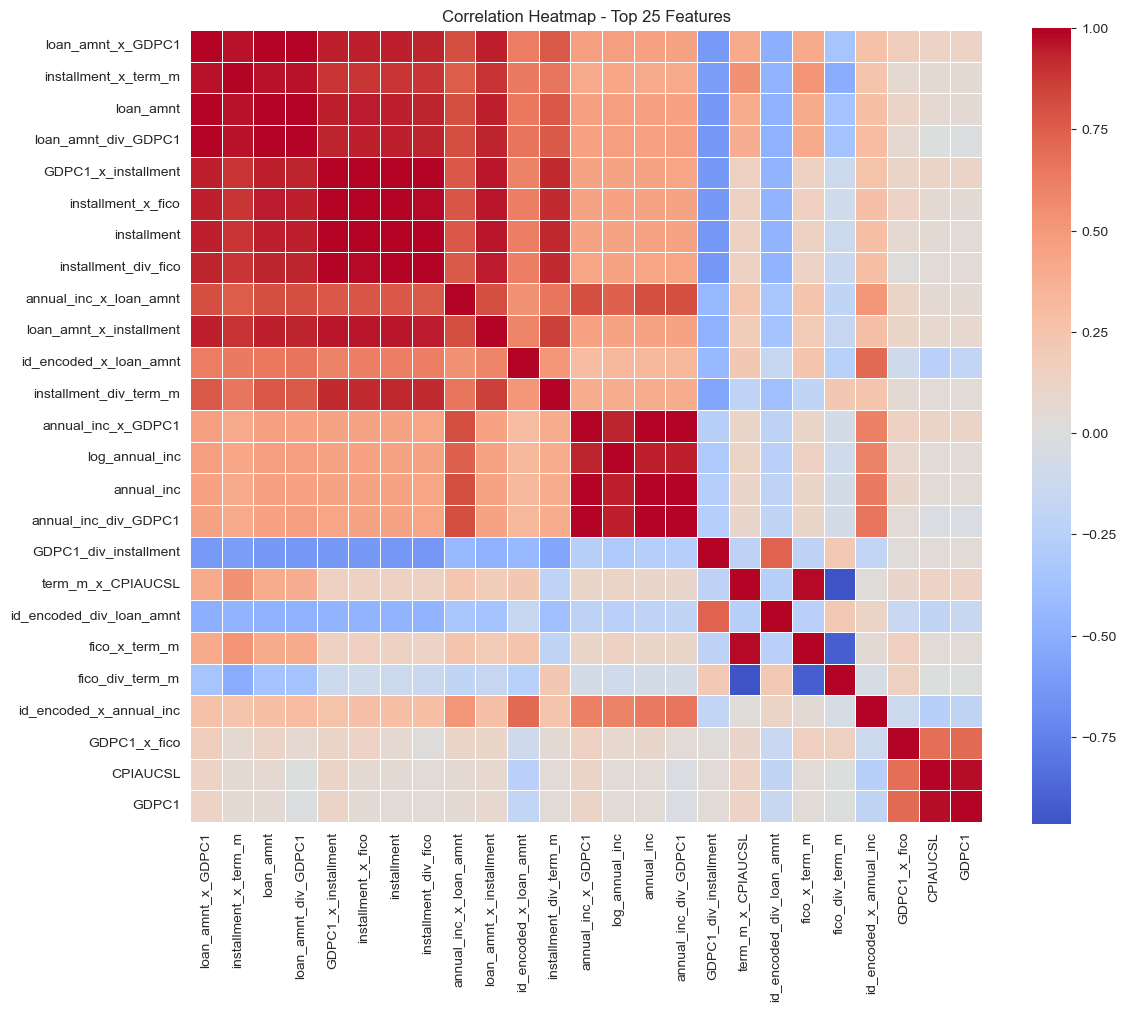


High correlations (>0.8):
  loan_amnt ↔ installment: 0.946
  loan_amnt ↔ annual_inc_x_loan_amnt: 0.813
  loan_amnt ↔ loan_amnt_x_GDPC1: 0.997
  loan_amnt ↔ loan_amnt_div_GDPC1: 0.997
  loan_amnt ↔ loan_amnt_x_installment: 0.939
  loan_amnt ↔ GDPC1_x_installment: 0.944
  loan_amnt ↔ installment_x_fico: 0.948
  loan_amnt ↔ installment_div_fico: 0.936
  loan_amnt ↔ installment_x_term_m: 0.969
  term_m ↔ loan_amnt_div_installment: 0.838
  term_m ↔ fico_x_term_m: 0.982
  term_m ↔ fico_div_term_m: -0.973
  term_m ↔ term_m_x_CPIAUCSL: 0.994
  installment ↔ loan_amnt_x_GDPC1: 0.941
  installment ↔ loan_amnt_div_GDPC1: 0.944
  installment ↔ loan_amnt_x_installment: 0.958
  installment ↔ GDPC1_x_installment: 0.997
  installment ↔ installment_x_fico: 0.996
  installment ↔ installment_div_fico: 0.996
  installment ↔ installment_x_term_m: 0.892
  installment ↔ installment_div_term_m: 0.926
  annual_inc ↔ log_annual_inc: 0.943
  annual_inc ↔ annual_inc_x_loan_amnt: 0.814
  annual_inc ↔ annual_inc_x

In [32]:
# STEP 8: CORRELATION ANALYSIS 
print_step("8. CORRELATION ANALYSIS & VISUALIZATION")
import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib to interactive mode for VSCode
plt.ion()

corr_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ID_COLS][:50]
corr_matrix = df[corr_cols].corr()

# Target correlation
if TARGET_COL in corr_matrix.columns:
    target_corr = corr_matrix[TARGET_COL].sort_values(ascending=False)
    print(f"\nTop 10 correlated with {TARGET_COL}:\n{target_corr.head(11)[1:]}")
    
    plt.figure(figsize=(10, 5))
    target_corr[1:16].plot(kind='barh')
    plt.title(f'Top 15 Correlations with {TARGET_COL}')
    plt.tight_layout()
    plt.savefig('../data_work/target_corr.png', dpi=120, bbox_inches='tight')
    print("✓ Saved: target_corr.png")
    plt.show()  

# Heatmap (top 25)
top_25 = corr_matrix.abs().sum().sort_values(ascending=False).head(25).index
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_25].corr(), cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap - Top 25 Features')
plt.tight_layout()
plt.savefig('../data_work/heatmap.png', dpi=120, bbox_inches='tight')
print("✓ Saved: heatmap.png")
plt.show()  

# High correlations
print("\nHigh correlations (>0.8):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            print(f"  {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

print(f"\n{'='*60}\nPIPELINE COMPLETE!\n{'='*60}")